## Dynamic flux based analysis


dFBA is used to simulate the fermenation processes using our strain.

Here we try to maximize psilocybin production, and visualize the psilocybin production over time, with glucose as the carbon source.

#### Introductory stuff - import of various libraries needed for DFBA and the model

In [1]:
%run 01-model.ipynb

from dfba import DfbaModel, ExchangeFlux, KineticVariable
from dfba.plot.matplotlib import *

'' is not a valid SBML 'SId'.


Defining the model objective to optimize the psilosybin synthase along with optimization of the model 

In [2]:
model.objective = model.reactions.psiM
model.optimize();

### DFBA starts here

The solver is set to glpk

In [3]:
model.solver = "glpk"
dfba_model = DfbaModel(model)

The apparent important metabolites for psilosybin production are added to the model as kinetic variables.

In [4]:
X = KineticVariable("Biomass")
Glc = KineticVariable("Glucose")
Psi = KineticVariable("Psilocybin")
Oxy = KineticVariable("Oxygen")

dfba_model.add_kinetic_variables([X, Glc, Psi, Oxy])

Adding the exchange fluxes to appear the model using the reaction ID's

In [5]:
mu = ExchangeFlux("DRAIN_Biomass")
v_G = ExchangeFlux("BOUNDARY_GLCe")
v_Psi = ExchangeFlux("psiM")
v_O = ExchangeFlux("BOUNDARY_O2e")

dfba_model.add_exchange_fluxes([mu, v_G, v_Psi, v_O])

Adding the right hand expressions for calculating the time derivative of each kinetic variable.

In [6]:
dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Glucose", v_G * 180.1559/1000 * X)
dfba_model.add_rhs_expression("Psilocybin", v_Psi * 284.25/1000.0 * X)
dfba_model.add_rhs_expression("Oxygen", 0) # O2 is kept constant

Adding expressions for calculating lower/upper bounds of the selected exchange fluxes. 

In [7]:
dfba_model.add_exchange_flux_lb("BOUNDARY_GLCe", 2.5 * (Glc / (0.0027 + Glc)), Glc)
dfba_model.add_exchange_flux_lb("BOUNDARY_O2e", 15.0 * (Oxy / (0.024 + Oxy)), Oxy)
dfba_model.add_exchange_flux_lb("psiM", 3.14 * (Psi / (0.01 + Psi)), Psi)

Adding initial conditions. Biomass is set high and kept constant, as psilocyibin is set as the objective -> all glucose will be used for converstion to psilocybin.

In [8]:
dfba_model.add_initial_conditions(
    {
        "Biomass": 1,         # (gDW/L)
        "Glucose": 20.0,      # (g/L)
        "Psilocybin": 0.0,    # (g/L)
        "Oxygen": 39          # (mmol/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 75.0, 0.5, ["BOUNDARY_GLCe", "psiM"])

Plotting the concentrations and tradjectories.

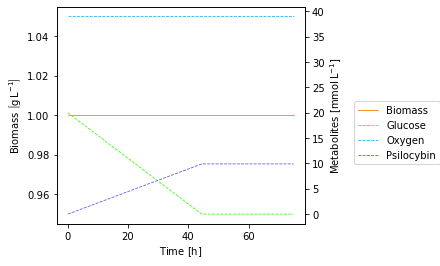

In [9]:
plot_concentrations(concentrations)

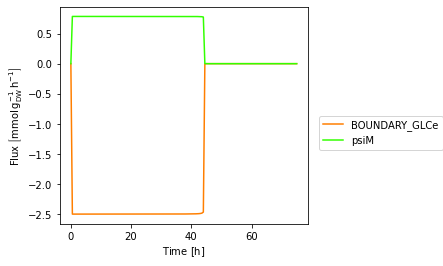

In [10]:
plot_trajectories(trajectories)

As the reader may notice, the above plots doesn't give the full picture as trp, the precurser to psilocybin, is not in the picture. Therefore, new caluclations will be performed adding trp to the model.

In [11]:
Trp = KineticVariable("Tryptophan")
dfba_model.add_kinetic_variables([Trp])

v_Trp = ExchangeFlux("r385")
dfba_model.add_exchange_fluxes([v_Trp])

dfba_model.add_rhs_expression("Tryptophan", v_Trp * 204.22/1000.0 * X)

dfba_model.add_exchange_flux_lb("r385", 0.7 * (Trp / (0.3 + Trp)), Trp)

Setting the initial conditions while including trp

In [12]:
dfba_model.add_initial_conditions(
    {
        "Biomass": 1,         # (gDW/L)
        "Tryptophan": 0.0001, # (g/L)
        "Glucose": 20.0,      # (g/L)
        "Psilocybin": 0.0,    # (g/L)
        "Oxygen": 39          # (mmol/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 100.0, 0.5, ["BOUNDARY_GLCe", "r385", "psiM"])

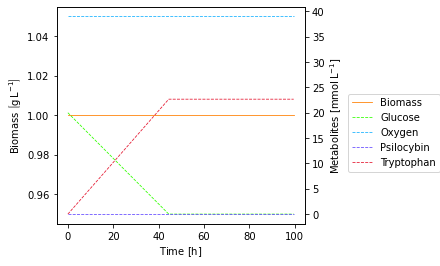

In [13]:
plot_concentrations(concentrations)

As seen from the plot, no trp is converted to psilocybin. Therefore, we tried to increase the simulation time and the glucose concentration, to see how, this would affect the simulation.

In [14]:
dfba_model.add_initial_conditions(
    {
        "Biomass": 1,         # (gDW/L)
        "Tryptophan": 0.0001, # (g/L)
        "Glucose": 200.0,      # (g/L)
        "Psilocybin": 0.0,    # (g/L)
        "Oxygen": 39          # (mmol/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 1000.0, 0.5, ["BOUNDARY_GLCe", "r385", "psiM"])

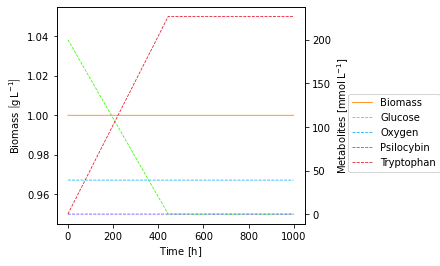

In [15]:
plot_concentrations(concentrations)

As nothing was changed, except the glucosce concentration and runtime, no changes was expected in the plot. However, to try and fix this, we set the lower bounds of psiM to be high and therefore, try to push the flux towards psilocybin production.

In [16]:
model.reactions.psiM.lower_bounds = 100
model.optimize();

In [17]:
dfba_model.add_initial_conditions(
    {
        "Biomass": 1,         # (gDW/L)
        "Tryptophan": 0.0001, # (g/L)
        "Glucose": 20.0,      # (g/L)
        "Psilocybin": 0.0,    # (g/L)
        "Oxygen": 39          # (mmol/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 200.0, 0.5, ["BOUNDARY_GLCe", "r385", "psiM"])

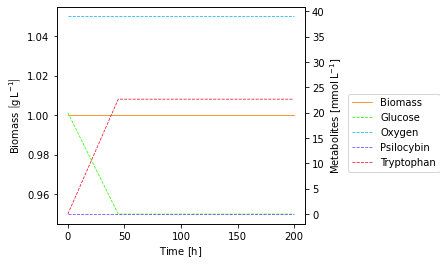

In [18]:
plot_concentrations(concentrations)

As seen from the plot above no psilocybin is produced. This may be because reaction flux is not forced through the psilocybin pathway.